<a href="https://colab.research.google.com/github/youssef819/Projet-ChatBot/blob/main/TD3_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD3: Vision Transformer (ViT)

In this TD, you must modify this notebook to complete the code (**# TO DO comments**) and complete the **proposed experiments**. To do this,

1. Fork this repository
2. Clone your forked repository on your local computer
3. Add your code and answer the questions
4. Commit and push regularly

**The last commit is due on Wednesday, January 8, 2025**. Later commits will not be taken into account.

As the computation is heavy, particularly during training, we encourage you to use a GPU. If your laptob is not equiped, you may use one of these remote jupyter servers, where you can select the execution on GPU :

1) [jupyter.mi90.ec-lyon.fr](https://jupyter.mi90.ec-lyon.fr/)

This server is accessible within the campus network. If outside, you need to use a VPN. Before executing the notebook, select the kernel "Python PyTorch" to run it on GPU and have access to PyTorch module.

2) [Google Colaboratory](https://colab.research.google.com/)

Before executing the notebook, select the execution on GPU : "Exécution" Menu -> "Modifier le type d'exécution" and select "T4 GPU".

### Goal of the TD

Transformers have been introduced by [Vaswani et al. in 2017](https://arxiv.org/abs/1706.03762) in the context of NLP (Natural Language Processing), and particulary for Machine Translation.

Its great success has led to its adaptation to various applications, including image classification. In this trend, [Dosovitskiy et al. in 2020](https://arxiv.org/abs/2010.11929) have proposed Vision Transformers (ViT) that we will study and implement from scratch in this TD.

The principle is illustrated in the following picture from this paper.

![Vision Tranformers](./figures/vit.png "Vision Transformers")

First, an input image is “cut” into sub-images equally sized.

Each such sub-image goes through a linear embedding. From then, each sub-image becomes a one-dimensional vector.

A positional embedding is then added to these vectors (tokens). The positional embedding allows the network to know where each sub-image is positioned originally in the image. Without this information, the network would not be able to know where each such image would be placed, leading to potentially wrong predictions.

These tokens are then passed, together with a special classification token, to the transformer encoders blocks, were each is composed of : A Layer Normalization (LN), followed by a Multi-head Self Attention (MSA) and a residual connection. Then a second LN, a Multi-Layer Perceptron (MLP), and again a residual connection. These blocks are connected back-to-back.

Finally, a classification MLP head is used for the final classification only on the special classification token, which by the end of this process has global information about the picture.


### Implementation of the ViT model

First, we import the required modules.

In [2]:
# Import modules
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

For this first experiment, we will use the MNIST dataset that contains 28x28 binary pixels images of hand-written digits ([0–9]).

In [3]:
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data import Subset, DataLoader

# Load data
transform = ToTensor()

train_set = MNIST(
    root="datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
    root="datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.93MB/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [4]:
# Let's check our loaders' dimensions
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


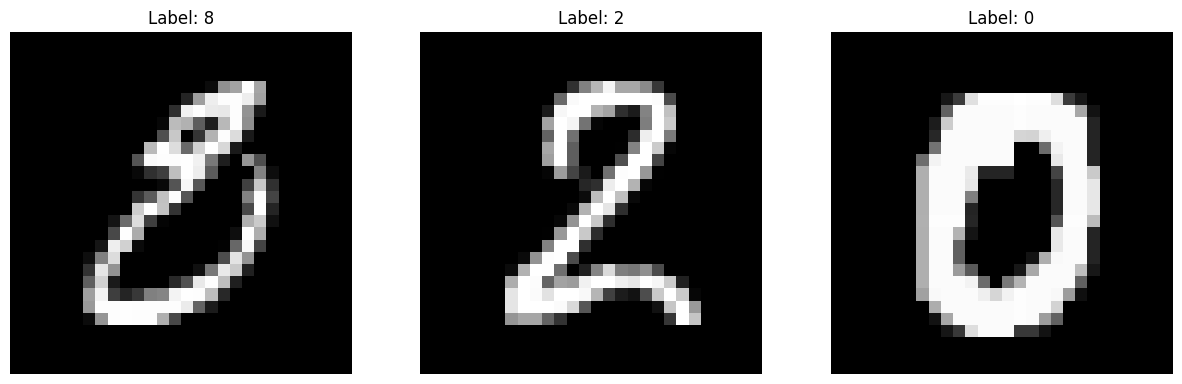

In [5]:
# Have a look at some training pictures
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 3 images

for i in range(3):
    image = images[i]
    label = labels[i].item()

    image = image.numpy().transpose((1, 2, 0))
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()


### "Patchification"
The transformer encoder was originally developed with sequence data in mind, such as English sentences. However, as an image is not a sequence, we need to “sequencify” an image. To do this, we break it into multiple sub-images and map each sub-image to a vector.

We do so by simply reshaping our input, which has size (N, C, H, W), where N is the batch size, C the number of channels and (H,W) the image dimension. In the case of MNIST, dimensions are (N, 1, 28, 28). The target dimension is (N, #Patches, Patch dimensionality), where the dimensionality of a patch is adjusted accordingly.

In this example, we break each (1, 28, 28) into 7x7 patches (hence, each of size 4x4). That is, we are going to obtain 7x7=49 sub-images out of a single image.

Thus, we reshape input (N, 1, 28, 28) to (N, PxP, C x H/P x W/P) = (N, 49, 16)

Notice that, while each patch is a picture of size 1x4x4, we flatten it to a 16-dimensional vector. Also, in this case, we only had a single color channel. If we had multiple color channels, those would also have been flattened into the vector.

In [6]:
def patchify(images, n_patches):
    # n_patches: number of height/width divisions of the input image
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    # Patches dimensions: (N, P*P, C * H/P * W/P)
    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patches = patches.to(device)
    patch_size = h // n_patches

    # Image dimensions: (C, H, W)
    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                # Patch dimensions: (C, H/P, W/P)
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten() # patch.flatten() dimensions: (C * H/P * W/P)
    return patches



### Linear embedding

Now that we have our flattened patches, we can map each of them through a Linear mapping. While each patch was a 4x4=16 dimensional vector, the linear mapping can map to any arbitrary vector size. Thus, we will use for this a parameter `hidden_d` for "hidden dimension".

In this example, we will use a hidden dimension of 8, but in principle, any number can be put here. We will thus be mapping each 16-dimensional patch to an 8-dimensional patch.


### Positional encoding

Positional encoding allows the model to understand where each patch would be placed in the original image. While it is theoretically possible to learn such positional embeddings, previous work by [Vaswani et al. in 2017](https://arxiv.org/abs/1706.03762) suggests that we can just add sines and cosines waves.

In particular, positional encoding adds high-frequency values to the first dimensions and lower-frequency values to the latter dimensions.

In each sequence, for token i we add to its j-th coordinate the following value:

![Positional encoding](./figures/positional_encoding.png "Positional encoding").

This positional embedding is a function of the number of elements in the sequence and the dimensionality of each element. Thus, it is always a 2-dimensional tensor or “rectangle”.

Here is a simple function that, given the number of tokens and the dimensionality of each of them, outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.

This positional encoding is added to our model after the linear mapping and the addition of the class token.

In [7]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

### Multi-Head Self-Attention

The objective is now that, for a single image, each patch has to be updated based on some similarity measure with the other patches. We do so by linearly mapping each patch (that is now an 8-dimensional vector in our example) to 3 distinct vectors: q, k, and v (query, key, value).

Then, for a single patch, we are going to compute the dot product between its q vector with all of the k vectors, divide by the square root of the dimensionality of these vectors (sqrt(8)), softmax these so-called attention cues, and finally multiply each attention cue with the v vectors associated with the different k vectors and sum all up.

In this way, each patch assumes a new value that is based on its similarity (after the linear mapping to q, k, and v) with other patches. This whole procedure, however, is carried out H times on H sub-vectors of our current 8-dimensional patches, where H is the number of Heads.

Once all results are obtained, they are concatenated together. Finally, the result is passed through a linear layer (for good measure).

The intuitive idea behind attention is that it allows modeling the relationship between the inputs. What makes a ‘0’ a zero are not the individual pixel values, but how they relate to each other.

This is implemented in the MSA class:

In [8]:
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super().__init__()
        self.d = d # Embedding space dimension
        self.n_heads = n_heads # Number of heads into an attention block (run in parallel)

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        # Attention sub space dimension is equal to d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # N: batch size
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            # sequence has shape (seq_length, token_dim)
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                # seq has shape (seq_length, d_head)
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                # relevance_score: relevance between query Qi and key Kj (dot production)
                relevance_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_head, dtype=torch.float32))
                # q has shape (seq_length, d_head), k has shape (seq_length, d_head)
                # then relevance_scores has shape (seq_length, seq_length)

                # normalized_relevance_score: normalize scores into probabilities for each query along keys
                normalized_relevance_scores = F.softmax(relevance_scores, dim = -1)

                attention = torch.matmul(normalized_relevance_scores, v)
                # can be seen as a weighted sum of how to move the original token embedding
                # under the influence of relevant other tokens in the sentence. We refine the
                # token embedding.

                seq_result.append(attention)

            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

Notice that, for each head, we create distinct Q, K, and V mapping functions (square matrices of size 4x4 in our example).

Since our inputs will be sequences of size (N, 50, 8), and we only use 2 heads, we will at some point have an (N, 50, 2, 4) tensor, use a nn.Linear(4, 4) module on it, and then come back, after concatenation, to an (N, 50, 8) tensor.

Also notice that using loops is not the most efficient way to compute the multi-head self-attention, but it makes the code much clearer for learning.

### Transformer Encoder Blocks

The next step is to create the transformer encoder block class.

Layer normalization (LN) is a popular block that, given an input, subtracts its mean and divides by the standard deviation. It is applied to the last dimension only. We can thus make each of our 50x8 matrices (representing a single sequence) have mean 0 and std 1. After we run our (N, 50, 8) tensor through LN, we still get the same dimensionality.

Also, We will be using residual connection that consists in adding the original input to the result of some computation. This, intuitively, allows a network to become more powerful while also preserving the set of possible functions that the model can approximate.

We will add a residual connection that will add our original (N, 50, 8) tensor to the (N, 50, 8) obtained after LN and MSA.

Next is to add a simple residual connection between what we already have and what we get after passing the current tensor through another LN and an MLP. The MLP is composed of two layers, where the hidden layer typically is four times as big (this is a parameter).

The transformer encoder block class (which will be a component of the future ViT class) is thus as follows:

In [9]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super().__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        x = self.mhsa(self.norm1(x)) + x
        x = self.mlp(self.norm2(x)) + x
        # after the forward pass, output has shape (batch_size, #patch + 1, patch_dimensionality). In our case (N, 50, 8)
        return x


### ViT model

Now that the encoder block is ready, we just need to insert it in our bigger ViT model which is responsible for patchifying before the transformer blocks, and carrying out the classification after.

To help classification, we will use an additional **classification token** to the input sequence. This is a special token that we add to our model that has the role of capturing information about the other tokens. This will happen with the MSA block. When information about all other tokens will be present here, we will be able to classify the image using only this special token. The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.

Thus, we will add a parameter to our model and convert our (N, 49, 8) tokens tensor to an (N, 50, 8) tensor (we add the special token to each sequence).

We could have an arbitrary number of transformer blocks. In this example, to keep it simple, I will use only 2. We also add a parameter to know how many heads does each encoder block will use.

Finally, we can extract just the classification token (first token) out of our N sequences, and use each token to get N classifications.

Since we decided that each token is an 8-dimensional vector, and since we have 10 possible digits, we can implement the classification MLP as a simple 8x10 matrix, activated with the SoftMax function.

The output of our model shoud be an (N, 10) tensor.

In [10]:
class ViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super().__init__()

        # Attributes
        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1]) # in our case chw[0] = 1
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d), # correspond to all patches + classification token
            persistent=False,
        )

        # 4) Transformer encoder blocks: we chose to use only 2
        self.blocks = nn.ModuleList(
            [ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):

        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches) # patches dimensions: (N, P*P, C * H/P * W/P)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        # linear mapper: (N, P*P, C * H/P * W/P) -> (N, P*P, hidden_d)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        # let's repeat class_token for for batch_size (n), once per patch (1) and keep its dimension hidden_d (-1)
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim= 1) # (N, P*P + 1, hidden_d)

        # Adding positional embedding

        # let's repeat positional_embeddings for each sequence in the batch (n) and keep other dimensions
        positional_embeddings = self.positional_embeddings.expand(n, -1, -1) # (N, P*P+1, hidden_d)
        out = tokens + positional_embeddings

        # Transformer Blocks (2)
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0:1, :] # (N, 1, hidden_d)

        # Map to output dimension, output category distribution
        out = self.mlp(out) # (N, out_d)

        return out

### ViT training

The ViT model being built, the next step is to train it on the MNIST dataset.

First, we initialize the model and the hyperparameters.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "Using device: ",
    device,
    f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
)

model = ViT(
    (1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10
).to(device)

N_EPOCHS = 5
LR = 0.005

Using device:  cuda (Tesla T4)


Training of the ViT model:

In [ ]:
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        loss.backward()
        optimizer.step()


    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")


PATH = "ViT.pth"

# save model
torch.save({
    'epoch': N_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss,
}, PATH)

print("Model saved !")

Epoch 1/5 loss: 2.10
Epoch 2/5 loss: 1.81
Epoch 3/5 loss: 1.72
Epoch 4/5 loss: 1.69
Epoch 5/5 loss: 1.66
Model saved !


### ViT test

Finally, let's test the trained model.

In [ ]:
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        y_hat = model(x) # (N, out_d)
        test_loss = criterion(y_hat, y)

        _, predicted = torch.max(y_hat, 1)
        correct += (predicted == y).sum().item()
        total += len(y)


    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")


Test loss: 1.63
Test accuracy: 82.28%


Test loss is close to the train loss (1.63 vs 1.66). Howerver, it would have been more careful to use a validation set while updating model weights

## Further experiments

1. Adapt the code to apply the ViT model on CIFAR dataset.
2. Make use of a validation set to evaluate overfitting.
3. Evaluate the model with a dimension of 16 for the tokens and 4 encoder blocks.

In [70]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Load data
transform = ToTensor()

train_set = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

# train_set = Subset(train_set, indices=list(range(1000)))
# test_set = Subset(test_set, indices=list(range(100)))

# 45.000 training images, 5.000 validation images, 10.000 test images
train_size = int(0.9 * len(train_set))  # 90% of training set for training
val_size = len(train_set) - train_size  # 10% of training set for validation
train_set, val_set = random_split(train_set, [train_size, val_size])


train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

data_loaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader,
}

Files already downloaded and verified
Files already downloaded and verified


In [71]:
# Let's check dimensions
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 45000
Validation set size: 5000
Test set size: 10000


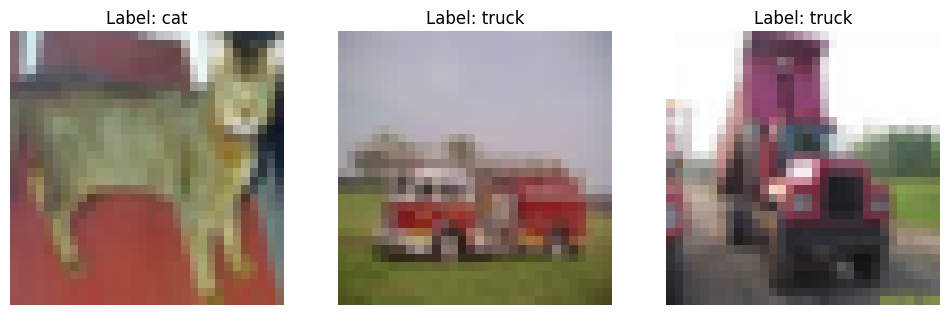

In [72]:
# Let's take a look at some pictures with their label in train set
data_iter = iter(train_loader)
images, labels = next(data_iter)

# class name list
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# display 3 images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    img = images[i]
    img = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {classes[labels[i]]}")
plt.show()

In this section we deal with 3 color channel images. Size patch is (3, 32, 32).
Let's break each image into 8x8 patches (hence, each of size 4x4). We are going to obtain
8x8 = 64 sub-images out of a single image.

Thus, we reshape input (N, 3, 32, 32) to (N, PxP, C x H/P x W/P) = (N, 64, 48)

Each patch is a picture of size 3x4x4, we flatten it to a 48-dimensional vector.

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "Using device: ",
    device,
    f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
)

# CIFAR10 has 10 classes
# As suggested: hidden_d = 16 and n_blocks = 4
model_CIFAR10 = ViT(
    (3, 32, 32), n_patches=8, n_blocks=4, hidden_d=16, n_heads = 2, out_d=10
).to(device)


N_EPOCHS = 5
LR = 0.005

Using device:  cuda (Tesla T4)


In [ ]:
import time
import copy

optimizer = Adam(model_CIFAR10.parameters(), lr=LR)
criterion = CrossEntropyLoss()

# Keep track of the time needed for training
since = time.time()

train_accuracies = []
val_accuracies = []
best_model_wts = copy.deepcopy(model_CIFAR10.state_dict())
best_acc = 0.0

epoch_time = []  # we'll keep track of the time needed for each epoch

for epoch in range(N_EPOCHS):

    # Keep track of the time needed for each epoch
    epoch_start = time.time()
    print("Epoch {}/{}".format(epoch + 1, N_EPOCHS))
    print("-" * 10)

    # Each epoch has a training and validation phase
    for phase in ["train", "val"]:

        print( ' ***' + str(phase) + '*** ')

        if phase == "train":
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in data_loaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in training phase
            outputs = model_CIFAR10(inputs)
            outputs = outputs.squeeze(1) # from (128, 1, 10) to (128, 10)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.detach().cpu().item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data) # Number of correct predictions

            # backward + optimize only if in training phase
            if phase == "train":
                loss.backward() # Compute the gradient
                optimizer.step() # Update the weights

        epoch_loss = running_loss / len(data_loaders[phase]) # Average loss over all batches
        epoch_acc = running_corrects.double() / len(data_loaders[phase].dataset)

        # Let's keep a track of training and validation accuracies over epochs
        train_accuracies.append(epoch_acc.item()) if phase == "train" else val_accuracies.append(epoch_acc.item())

        print("{} Loss: {:.2f} Acc: {:.2f}".format(phase, epoch_loss, epoch_acc))

        # Deep copy the model if it's the best one so far
        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model_CIFAR10.state_dict())

    # Add the epoch time
    t_epoch = time.time() - epoch_start
    epoch_time.append(t_epoch)

# Print the time needed for the entire training
time_elapsed = time.time() - since
print(
    "Training complete in {:.0f}m {:.0f}s".format(
        time_elapsed // 60, time_elapsed % 60
    )
)

# Print the best accuracy on validation set
print("Best val Acc: {:4f}".format(best_acc))

# Load best model weights
model_CIFAR10.load_state_dict(best_model_wts)

Epoch 1/5
----------
 ***train*** 
train Loss: 279.40 Acc: 0.26
 ***val*** 
val Loss: 268.08 Acc: 0.31
Epoch 2/5
----------
 ***train*** 
train Loss: 272.25 Acc: 0.32
 ***val*** 
val Loss: 261.88 Acc: 0.36
Epoch 3/5
----------
 ***train*** 
train Loss: 269.54 Acc: 0.34
 ***val*** 
val Loss: 264.25 Acc: 0.34
Epoch 4/5
----------
 ***train*** 


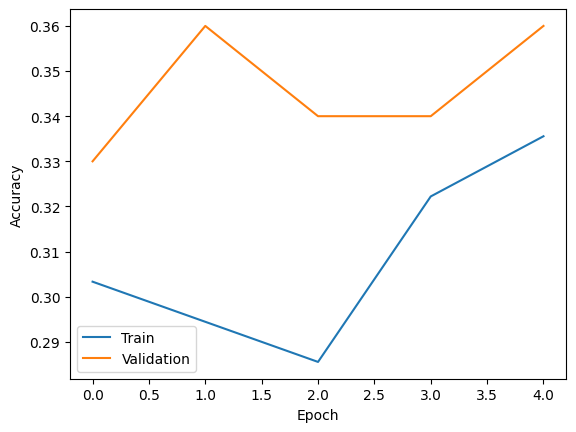

In [68]:
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We use a validation test to avoid overfitting. Over an epoch, model weights are updated only if the accuracy on this set decrease (update if the model learns).

In [69]:
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        y_hat = model_CIFAR10(x) # (N, out_d)
        y_hat = y_hat.squeeze(1)

        _, predicted = torch.max(y_hat, 1)
        correct += (predicted == y).sum().item()
        total += len(y)


    print(f"Test accuracy: {correct / total * 100:.2f}%")

Test accuracy: 39.00%
